In [25]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import time
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1c675060148>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
test_data[:3]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0


In [5]:
print(len(train_data))
print(len(test_data))

150000
50000


중복 확인

In [6]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [7]:
# 중복 제거 
train_data.drop_duplicates(subset=['document'], inplace=True)
print(len(train_data))

146183


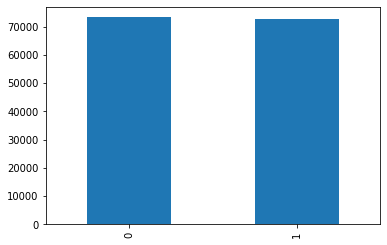

In [8]:
train_data['label'].value_counts().plot(kind='bar')

In [9]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


null 확인

In [10]:
train_data.isnull().values.any()

True

In [11]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [12]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [13]:
#na 제거
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


정규표현식

In [14]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]','')
train_data[:10]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


In [15]:
train_data['document'].replace('',np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [16]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [17]:
train_data = train_data.dropna(how='any')

In [18]:
len(train_data)

145791

In [19]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how="any")
print('전처리 후 테스트 샘플 개수: ', len(test_data))

전처리 후 테스트 샘플 개수:  48995


### 토큰화

In [20]:
# 불용어 제거 
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [22]:
# 형태소 분석기 (띄어쓰기의 한계 때문에)
okt = Okt()
okt.morphs("아 더빙 진짜 짜증나네요 목소리", stem = True)# stem 정규화 여부

['아', '더빙', '진짜', '짜증나다', '목소리']

In [26]:
start = time.time()
X_train = []

for sentence in train_data['document']:
    temp_x = []
    temp_x = okt.morphs(sentence, stem=True)
    temp_x = [word for word in temp_x if not word in stopwords]
    X_train.append(temp_x)
    
print('소요시간: ', (time.time()-start)/60, '분')
    
print(X_train[:3])    

소요시간:  10.753950782616933 분
[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [27]:
len(X_train)

145791

In [29]:
X_test = []
for sentence in test_data['document']:
    temp_x = []
    temp_x = okt.morphs(sentence, stem=True)
    temp_x = [word for word in temp_x if not word in stopwords]
    X_test.append(temp_x)



### 정수 인코딩

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [35]:
len(tokenizer.word_index) # 높은 정수일수록 낮은 빈도수 

43752

In [37]:
vocab_size = 19416

In [40]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)

# 텍스트를 숫자(정수) 시퀀스로
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


In [41]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [42]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) <1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [43]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


In [45]:
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

48745
48745


### 패딩

리뷰 최대 길이: 69
리뷰 평균 길이: 10.812485361182679


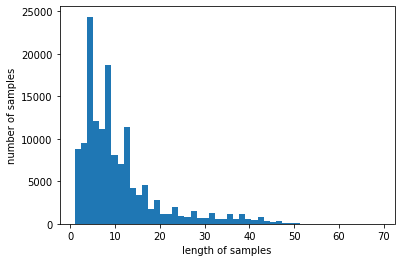

In [46]:
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [47]:
# 최적의 리뷰 max_len 은? --> max_len 이하인 샘플이 많으면서, 정보손실이 적어야
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1 
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt/len(nested_list))*100))        

In [48]:
max_len = 32
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 32 이하인 샘플의 비율: 95.1667791846351


In [49]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 리뷰 감성 분류

In [50]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [52]:
model = Sequential()
model.add(Embedding(vocab_size,64))
model.add(LSTM(128))
model.add(Dense(1, activation='relu'))

In [54]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [56]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es,mc], batch_size=32, validation_split=0.2)

Train on 116129 samples, validate on 29033 samples
Epoch 1/10
116128/116129 [============================>.] - ETA: 0s - loss: 0.5144 - acc: 0.8039
Epoch 00001: val_acc improved from -inf to 0.77453, saving model to best_model.h5
116129/116129 [==============================] - 87s 748us/sample - loss: 0.5144 - acc: 0.8039 - val_loss: 0.6255 - val_acc: 0.7745
Epoch 2/10
116096/116129 [============================>.] - ETA: 0s - loss: 0.4678 - acc: 0.8426
Epoch 00002: val_acc improved from 0.77453 to 0.84356, saving model to best_model.h5
116129/116129 [==============================] - 83s 716us/sample - loss: 0.4677 - acc: 0.8426 - val_loss: 0.4813 - val_acc: 0.8436
Epoch 3/10
116096/116129 [============================>.] - ETA: 0s - loss: 0.4740 - acc: 0.8569
Epoch 00003: val_acc did not improve from 0.84356
116129/116129 [==============================] - 83s 716us/sample - loss: 0.4740 - acc: 0.8568 - val_loss: 0.4561 - val_acc: 0.8412
Epoch 4/10
116064/116129 [===================

In [57]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f"%(loaded_model.evaluate(X_test, y_test)[1]))

48745/48745 [==============================] - 14s 282us/sample - loss: 0.6327 - acc: 0.8459

 테스트 정확도: 0.8459
